petgraph review: internals
---------------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 11.2019
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/petgraph/petgraph) [ipynb](./petgraph_review.ipynb)

petgraph is a rust library which allows you to work with graph data structures in rust.

In [2]:
:dep petgraph = "0.4.13"
:dep petgraph-evcxr = "*"

Internal representation of graphs by petgraph
------------------------------------------------------------------

This is the second part on a series about working with graphs in rust. The first part can be found [here](https://thobbs.cz/rust-play/petgraph_review.html).

Petgraph supports four different internal representations for graphs. The most common one is `Graph` which I have used throughout this tutorial.

- [`Graph`](https://docs.rs/petgraph/0.4.13/petgraph/graph/index.html) 
- [`StableGraph`](https://docs.rs/petgraph/0.4.13/petgraph/stable_graph/index.html)
- [`GraphMap`](https://docs.rs/petgraph/0.4.13/petgraph/graphmap/index.html)
- [`csr`](https://docs.rs/petgraph/0.4.13/petgraph/csr/index.html) (Compressed Sparse Row)

The `Graph` data structure
--------------------------------------

`Graph`s are stored like this:

```rust
pub struct Graph<N, E, Ty = Directed, Ix = DefaultIx> {
    nodes: Vec<Node<N, Ix>>,
    edges: Vec<Edge<E, Ix>>,
    ty: PhantomData<Ty>,
}
```
...

```rust
pub struct Node<N, Ix = DefaultIx> {
    /// Associated node data.
    pub weight: N,
    /// Next edge in outgoing and incoming edge lists.
    next: [EdgeIndex<Ix>; 2],
}
```
...

```rust
pub struct Edge<E, Ix = DefaultIx> {
    /// Associated edge data.
    pub weight: E,
    /// Next edge in outgoing and incoming edge lists.
    next: [EdgeIndex<Ix>; 2],
    /// Start and End node index
    node: [NodeIndex<Ix>; 2],
}
```
...

My first impression when looking at this code was "wait which order is the 'outgoing and incoming edge list' so I looked in the source code and found that there is actually an enum which indexes the duple. It can be found in [src/lib.rs](https://github.com/petgraph/petgraph/blob/45e8d931a786f0ab928aff6fa602fab4e418dbb8/src/lib.rs#L123). Yes Outgoing is first.

```rust
pub enum Direction {
    /// An `Outgoing` edge is an outward edge *from* the current node.
    Outgoing = 0,
    /// An `Incoming` edge is an inbound edge *to* the current node.
    Incoming = 1
}
```

Basically, what is going on, is that each `Node` has two doubly linked lists of `Edge`s associated with it. Now my next question, is how does a `Directed` Graph differ from an `Undirected` one in terms of internal representation?

I could have read the source code to figure that out, but I decided to have fun and instead visualize the datastructure by converting it to a graph.

In [3]:
/*
  In order to visualize the internals we need to make a bunch of fields public.
  We do so via an unsafe cast, refered to as a transumtation in rust.
  This method is described here:
  https://users.rust-lang.org/t/is-private-really-private/7826/15
*/
extern crate petgraph;
use petgraph::*;
use petgraph::dot::Dot;
use petgraph::graph::*;
use petgraph::prelude::*;
use petgraph::data::*;
use std::marker::PhantomData;
use petgraph_evcxr::draw_graph;

pub struct PubNode<N, Ix> {
    pub weight: N,
    pub next: [EdgeIndex<Ix>; 2],
}

pub struct PubEdge<E, Ix = DefaultIx> {
    /// Associated edge data.
    pub weight: E,
    /// Next edge in outgoing and incoming edge lists.
    pub next: [EdgeIndex<Ix>; 2],
    /// Start and End node index
    pub node: [NodeIndex<Ix>; 2],
}

pub struct PubGraph<N, E, Ty = Directed, Ix = DefaultIx> {
    pub nodes: Vec<PubNode<N, Ix>>,
    pub edges: Vec<PubEdge<E, Ix>>,
    pub ty: PhantomData<Ty>,
}

fn visualize_graph_internals<N, E, Ty, Ix>(g: &Graph<N, E, Ty, Ix>) -> Graph<String, String, petgraph::Directed>
    where
        N: std::fmt::Debug + Clone,
        E: std::fmt::Debug + Clone,
        Ty: EdgeType + Clone,
        Ix: std::fmt::Debug + IndexType + Clone,
{
    let mut v: Graph<String, String, petgraph::Directed> = Graph::new();
    let mut _g: Graph<N, E, Ty, Ix> = g.clone();
    let pub_g: PubGraph<N, E, Ty, Ix> = unsafe { std::mem::transmute(_g) };
    let mut nodes: Vec<NodeIndex> = vec![NodeIndex::new(0); g.node_count()];
    let mut edges: Vec<NodeIndex> = vec![NodeIndex::new(0); g.node_count()];
    for node_id in g.node_indices() {
        let w = format!("Node: {:?}", g.node_weight(node_id).unwrap());
        nodes[node_id.index()] = v.add_node(w.to_string());
    }
    for edge_id in g.edge_indices() {
        let w = format!("Edge: {:?}", g.edge_weight(edge_id).unwrap());
        edges[edge_id.index()] = v.add_node(w.to_string());
    }
    let mut add_link = |start: NodeIndex, end: usize, collection: Vec<NodeIndex>, label: &str| {
        match collection.get(end) {
            Some(dest) => {
                v.add_edge(start, *dest, label.to_string());
            },
            None => {
                let end_node = v.add_node("end".to_string());
                v.add_edge(start, end_node, label.to_string());
            },
        }
    };
    for (edge, edge_id) in pub_g.edges.iter().zip(g.edge_indices()) {
        let vedge_id = edges[edge_id.index()];
        add_link(vedge_id, edge.node[0].index(), nodes.clone(), "nodes[0]");
        add_link(vedge_id, edge.node[1].index(), nodes.clone(), "nodes[1]");
        add_link(vedge_id, edge.next[0].index(), edges.clone(), "next[0]");
        add_link(vedge_id, edge.next[1].index(), edges.clone(), "next[1]");
    }
    for (node, node_id) in pub_g.nodes.iter().zip(g.node_indices()) {
        let vnode_id = nodes[node_id.index()];
        add_link(vnode_id, node.next[0].index(), edges.clone(), "next[0]");
        add_link(vnode_id, node.next[1].index(), edges.clone(), "next[1]");
    }
    v
}

First lets look at an undirected graph; the `list` example from [the previous article](./petgraph_review.html).

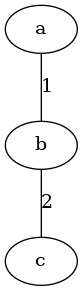

In [4]:
let mut list : Graph<&str, &str, petgraph::Undirected> = Graph::new_undirected();
let item1 = list.add_node("a");
let item2 = list.add_node("b");
let item3 = list.add_node("c");
list.add_edge(item1, item2, "1");
list.add_edge(item2, item3, "2");
draw_graph(&list);

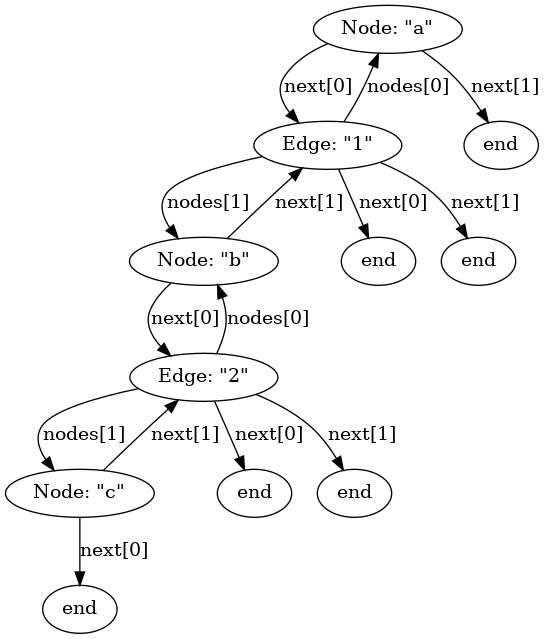

In [5]:
draw_graph(&visualize_graph_internals(&list));

Now lets look at a directed graph. I'll use the `tree` example.

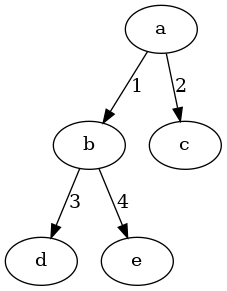

In [6]:
let mut tree : Graph<&str, &str, petgraph::Directed> = Graph::new();
let tree_item1 = tree.add_node("a");
let tree_item2 = tree.add_node("b");
let tree_item3 = tree.add_node("c");
let tree_item4 = tree.add_node("d");
let tree_item5 = tree.add_node("e");
tree.add_edge(tree_item1, tree_item2, "1");
tree.add_edge(tree_item1, tree_item3, "2");
tree.add_edge(tree_item2, tree_item4, "3");
tree.add_edge(tree_item2, tree_item5, "4");
draw_graph(&tree);

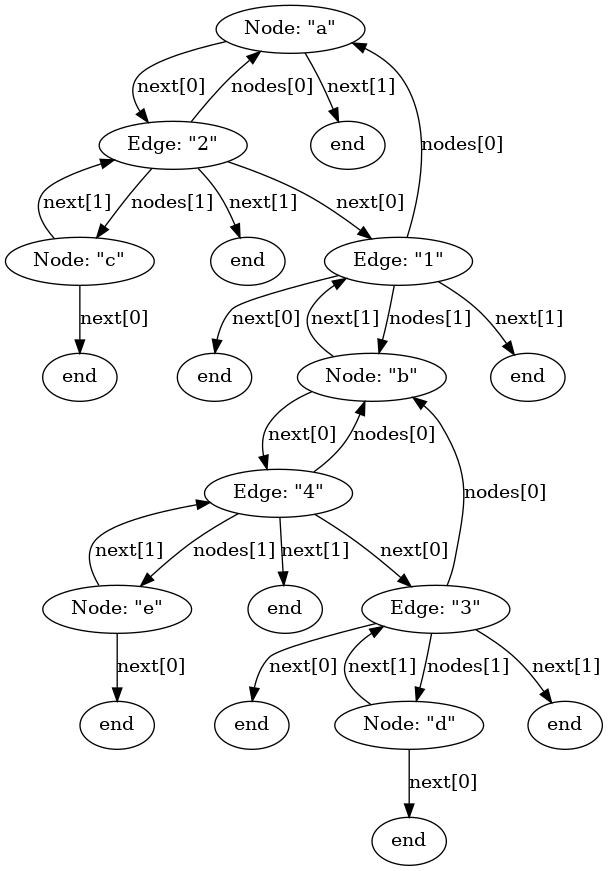

In [7]:
draw_graph(&visualize_graph_internals(&tree));

As you can see, directed and undirected graphs have the exact same internal representation.

To answer a question from earier "how do we convert from a directed to an undirected graph?" We can do so "unsafely" simply by using transmute.

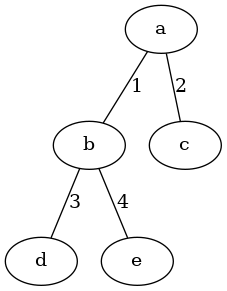

In [8]:
let undirected_tree : Graph<&str, &str, petgraph::Undirected> = unsafe {std::mem::transmute(tree.clone())};
draw_graph(&undirected_tree);

Of course, since we did a transmute and it worked, we know that the representation *should* be the same, lets just verify that.

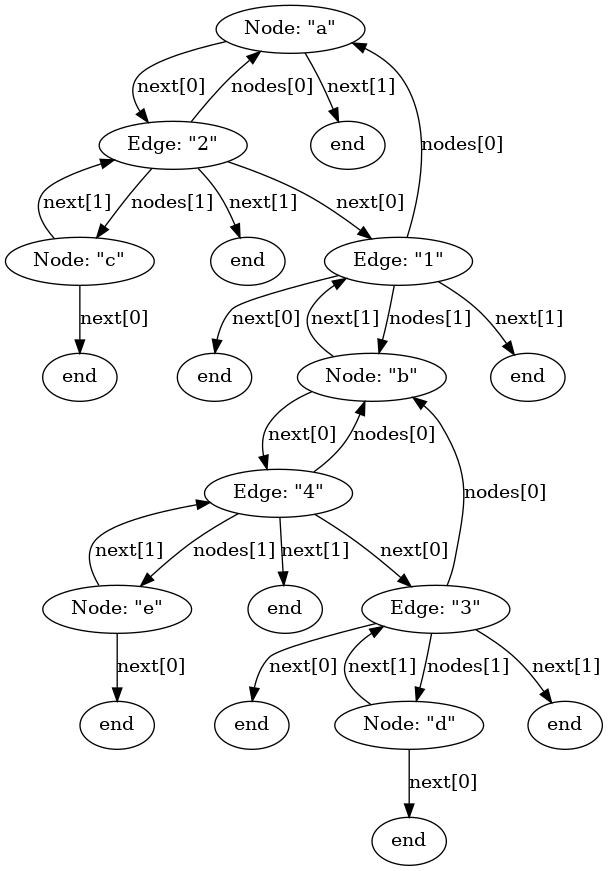

In [9]:
draw_graph(&visualize_graph_internals(&undirected_tree));

I'd like to point out some interesting consiquences of this data structure choice. One is that the doubly linked list of edges means that some nodes are "farther" from eachother than others in the data structure even though their theoretical distance is the same.

The distances between A → B and A → C are both 1 in the origional tree, but in the data structure, the distance from A → B is greater than that of A → C:

In [10]:
use std::collections::HashMap;
use petgraph::algo::*;

let udt_internals = visualize_graph_internals(&undirected_tree);
{
    fn print_path(
        g: &Graph<String, String, Directed>,
        start: &str,
        end: &str,
    ){
        let mut nodes: HashMap<&str, NodeIndex> = HashMap::new();
        for i in g.node_indices() {
            nodes.insert(g.node_weight(i).unwrap(), i);
        }
        let atob = astar(
            g,
            *nodes.get(start).unwrap(),
            | id | { *nodes.get(end).unwrap() == id },
            | _ | 0,
            | _ | 0,
        );
        let atobv = atob.unwrap().1;
        let atob_human: Vec<String> = atobv
            .iter()
            .map(| i | g.node_weight(*i).unwrap().clone())
            .collect();
        println!("Path from [{}] → [{}]:\n\t[{}]", start, end, atob_human.join("] → ["));        
    }
    print_path(&udt_internals, "Node: \"a\"", "Node: \"b\"");
    print_path(&udt_internals, "Node: \"a\"", "Node: \"c\"");
}

Path from [Node: "a"] → [Node: "b"]:
	[Node: "a"] → [Edge: "2"] → [Edge: "1"] → [Node: "b"]
Path from [Node: "a"] → [Node: "c"]:
	[Node: "a"] → [Edge: "2"] → [Node: "c"]


()

What are graphs and how should they be serialized?
----------------------------------------------------------------------------

When I open a text book on graph theory, perhaps "Graph Theory 4th edition Reinhard Diestel" I find a curios definition of a graph: "A *graph* is a pair G = (V, E) of sets such that E ⊆ \[V\]²; thus, the elements of E are 2-element subsets of V." Basically, what this means that in rust a graph is:

In [17]:
use std::hash::Hash;
use std::collections::HashSet;

pub struct MathGraph<T> {
    pub v: HashSet<T>,
    // pub e: HashSet<HashSet<T>>, Using a tuple is easier
    pub e: HashSet<(T, T)>,
}

impl<T: Hash + Eq + Copy> MathGraph<T> {
    pub fn get_matrix_square_of_v(&self) -> HashSet<(T,T)> {
        let mut res: HashSet<(T,T)> = HashSet::new();
        for vertex_a in self.v.iter() {
            let v_as_vec: Vec<_> = self.v.iter().collect();
            for vertex_b in v_as_vec.iter().rev() {
                res.insert((vertex_a.clone(), *vertex_b.clone()));
            }
        }
        res
    }
    
    pub fn valid(&self) -> bool {
        let matrix_square_of_v = self.get_matrix_square_of_v();
        for edge in self.e.iter() {
            if !matrix_square_of_v.contains(edge) {
                return false;
            }
        }
        return true;
    }
}

In [18]:
{
    let mut v: HashSet<usize> = HashSet::new();
    let mut e: HashSet<(usize, usize)> = HashSet::new();
    v.insert(1);
    v.insert(2);
    e.insert((1, 2));    
    let mut valid_example = MathGraph{
        v: v,
        e: e,
    };

    println!("Is valid graph? {:?}", valid_example.valid());
}

Is valid graph? true


()

In [15]:
{
    let mut v: HashSet<usize> = HashSet::new();
    let mut e: HashSet<(usize, usize)> = HashSet::new();
    v.insert(1);
    v.insert(2);
    e.insert((1, 3));    
    let mut invalid_example = MathGraph{
        v: v,
        e: e,
    };

    println!("Is valid graph? {:?}", invalid_example.valid());
}

Is valid graph? false


()

Diestel's graphs are profoundly uninteresting. In the previous article, I wrote about various applications of graph theory in real life; computer networks, electrical grids, dependency DAGs, interstate tarrif and tax calculations ect. None of these systems or structures consist of one set of vertexes and one set of edges in which the edges are two element subsets of the vertexes. Diestel has managed to take mathematics, which is supposed to be the study of the abstract and turned it into an inconsequential study of the concrete.

Let me provide you with a more interesting definition of a graph:

"A *graph* is any descrete structure or system who's topology could be described using a pair G = (V, E) of sets such that E ⊆ \[V\]²; thus, the elements of E are 2-element subsets of V. Graph theory is the study of the common principles and algorithms which can be applied to such structures."

This is an important distinction, I think, because the petgraph authors seem to have been under the impression that a graph *is* a set of vectors and a set of edges and ought to be serialized as such. This isn't in my opionion, the most efficient way of representing a graph.

**Note**: There are several differences between petgraph's `Graph` data structure and Diestel's "graph". First, Diestel's graph does not allow for there to be multiple edges between the same two nodes in any given direction. This is because the edge list is a set, and every element in a set must be unique. Secondly in petgraph, edges may have values (weights) associated with them.

Imagine if `Graph` was defined as:

In [20]:
pub struct TimGraph<N, E, Ty = Directed, Ix = DefaultIx> {
    nodes: Vec<TimNode<N, E, Ix>>,
    ty: PhantomData<Ty>,
}

pub struct TimNode<N, E, Ix = DefaultIx> {
    /// Associated node data.
    pub weight: N,
    /// Nodes with incoming edges
    pub incomming: HashSet<Ix>,
    /// Outgoing edges
    pub outgoing: Vec<(Ix, E)>,
}

This would ensure that equadistant vertexes would always be equadistant in the underlying data structure. Indeed, it would drastically reduce the number of hops required when traversing the graph. It would also reduce the number memory usage of the graph. Instead of storing 4 indexes per edge and 2 indexes per node, one would store at most two indexes per edge (and fewer in the case of a multigraph since the incoming edge set is a set). The data structure is also simpler and better represents a real graph structure because the edges are stored right next to the vertex's they connect.

[StableGraph](https://docs.rs/petgraph/0.4.13/petgraph/stable_graph/index.html)
------------------

When a node or edge in a `Graph` gets deleted, the `Vec`s of nodes and edges are repacked. This means that the indexes of all the nodes and edges which came after the deleted nodes and edges are invalidated. `StableGraph` solves this problem through some rather dirty tricks.

```rust
pub struct StableGraph<N, E, Ty = Directed, Ix = DefaultIx>
{
    g: Graph<Option<N>, Option<E>, Ty, Ix>,
    node_count: usize,
    edge_count: usize,

    // node and edge free lists (both work the same way)
    //
    // free_node, if not NodeIndex::end(), points to a node index
    // that is vacant (after a deletion).  The next item in the list is kept in
    // that Node's Node.next[0] field. For Node, it's a node index stored
    // in an EdgeIndex location, and the _into_edge()/_into_node() methods
    // convert.
    free_node: NodeIndex<Ix>,
    free_edge: EdgeIndex<Ix>,
}
```

When you delete a node in a stable graph, first, it disconnects the edge/node from the graph, then it marks the node/edge weight as `None`. `StableGraph`'s methods which do things such as iterating all nodes will ignore those who's weights are `None`. `StableGraph` stores a list of such "free" nodes/edges embeded in the graph as described in the comment.

[GraphMap](https://docs.rs/petgraph/0.4.13/petgraph/graphmap/index.html)
---------------

`GraphMap` aims to make it easy and fast to look up Nodes by their weights.

```rust
pub struct GraphMap<N, E, Ty> {
    nodes: OrderMap<N, Vec<(N, CompactDirection)>>,
    edges: OrderMap<(N, N), E>,
    ty: PhantomData<Ty>,
}
```

Unfortunately, it is not a well designed data structure. In most cases it is wasteful when it comes to space, time, and it (pointlessly) doesn't support multigraphs. Currently it takes 

```
(4 * size_of::<N>() + size_of::<E>() + 2 * size_of::<CompactDirection>() ) * |E| + size_of::<N>() * |V|
```

space.

A better design would be:

In [22]:
pub struct TimsGraphMapNode<N, E> {
    outgoing_edges: Vec<(N, E)>,
    nodes_that_point_here: HashSet<N>,
}

pub struct TimsGraphMap<N, E, Ty> {
    nodes: HashMap<N, TimsGraphMapNode<N, E>>,
    ty: PhantomData<Ty>,
}


This would support multigraphs, it would take at most the same number of OrderMap lookups to resolve an edge weight, but most of the time fewer lookups. It would take the following amount of space:

```
( 2 * size_of::<N>() + size_of::<E>() ) * |E| + size_of::<N>() * |V|
```

That said. If `size_of::<N>()` is small, you may find `GraphMap` usefull if you often need to look up Nodes by their node weight.

[`csr`](https://docs.rs/petgraph/0.4.13/petgraph/csr/index.html) (Compressed Sparse Row)
---------------------

